## Import dependencies

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import io

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             make_scorer, mean_squared_error,
                             precision_recall_curve, average_precision_score,
                             roc_curve, homogeneity_score, cohen_kappa_score,
                             RocCurveDisplay, auc)

# XGBoost library
import xgboost as xgb
from xgboost import plot_importance

# Joblib for model saving/loading
from joblib import dump, load



## Read csv file- source: https://ieee-dataport.org/open-access/evidence-detection-cloud-forensics

In [2]:
# Import necessary library for file upload in Google Colab
from google.colab import files

# Upload the CSV file
uploaded = files.upload()


Saving VMResourceUtilizationSlope.csv to VMResourceUtilizationSlope.csv


In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv(io.BytesIO(uploaded['VMResourceUtilizationSlope.csv']))

In [5]:
df.head()

,LAST_POLL,VMID,UUID,dom,rxbytes_slope,rxpackets_slope,rxerrors_slope,rxdrops_slope,txbytes_slope,txpackets_slope,...,vdard_bytes_slope,vdawr_reqs_slope,vdawr_bytes_slope,vdaerror_slope,hdard_req_slope,hdard_bytes_slope,hdawr_reqs_slope,hdawr_bytes_slope,hdaerror_slope,Status
0,1.604455e+09,6.945941,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,88.314189,29.913920,-0.015178,-0.110955,79.904093,5.455892,...,-0.167160,24.332609,89.836557,-0.051399,-0.106337,0.016691,-0.004758,-0.105207,0.022011,Normal
1,1.604455e+09,7.026220,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.746030,27.305131,0.096161,-0.002507,0.163125,0.229392,...,-0.025562,5.823226,89.957696,-0.038346,0.310258,0.097770,0.052514,0.042577,-0.028383,Attack
2,1.604455e+09,6.990172,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.800558,27.170820,-0.033997,-0.100880,-0.214256,0.083606,...,-0.046444,32.806824,90.188068,-0.082347,-0.202825,0.036052,-0.003892,-0.041009,0.069673,NaN
3,1.604455e+09,6.827498,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.918386,27.436180,-0.228990,-0.067816,0.040415,0.077278,...,-0.012109,4.223413,89.862735,0.063674,-0.017482,0.050728,0.061310,-0.070858,-0.092075,Normal
4,1.604455e+09,7.026633,"""fca7204b-7141-4055-82b7-b793b4694d70""",one-33,87.823056,25.667200,0.046009,0.115754,0.001009,-0.075827,...,0.161162,22.925104,89.905414,0.019181,0.012412,0.021613,0.149896,-0.155950,0.041561,Attack


In [6]:
# Check column names
df.columns

Index(['LAST_POLL', 'VMID', 'UUID', 'dom', 'rxbytes_slope', 'rxpackets_slope',
       'rxerrors_slope', 'rxdrops_slope', 'txbytes_slope', 'txpackets_slope',
       'txerrors_slope', 'txdrops_slope', 'timecpu_slope', 'timesys_slope',
       'timeusr_slope', 'state_slope', 'memmax_slope', 'mem_slope',
       'cpus_slope', 'cputime_slope', 'memactual_slope', 'memswap_in_slope',
       'memswap_out_slope', 'memmajor_fault_slope', 'memminor_fault_slope',
       'memunused_slope', 'memavailable_slope', 'memusable_slope',
       'memlast_update_slope', 'memdisk_cache_slope',
       'memhugetlb_pgalloc_slope', 'memhugetlb_pgfail_slope', 'memrss_slope',
       'vdard_req_slope', 'vdard_bytes_slope', 'vdawr_reqs_slope',
       'vdawr_bytes_slope', 'vdaerror_slope', 'hdard_req_slope',
       'hdard_bytes_slope', 'hdawr_reqs_slope', 'hdawr_bytes_slope',
       'hdaerror_slope', 'Status'],
      dtype='object')

# Input Data is imbalanced

In [7]:
# Check the values and count of target labels
df['Status'].value_counts()

Status
Normal    6448
Attack    2508
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9610 entries, 0 to 9609
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LAST_POLL                 9610 non-null   float64
 1   VMID                      9610 non-null   float64
 2   UUID                      9610 non-null   object 
 3   dom                       9610 non-null   object 
 4   rxbytes_slope             9594 non-null   float64
 5   rxpackets_slope           9594 non-null   float64
 6   rxerrors_slope            9594 non-null   float64
 7   rxdrops_slope             9594 non-null   float64
 8   txbytes_slope             9594 non-null   float64
 9   txpackets_slope           9594 non-null   float64
 10  txerrors_slope            9594 non-null   float64
 11  txdrops_slope             9594 non-null   float64
 12  timecpu_slope             9594 non-null   float64
 13  timesys_slope             9594 non-null   float64
 14  timeusr_

In [9]:
# Check for null values
df.isnull().sum()

LAST_POLL                     0
VMID                          0
UUID                          0
dom                           0
rxbytes_slope                16
rxpackets_slope              16
rxerrors_slope               16
rxdrops_slope                16
txbytes_slope                16
txpackets_slope              16
txerrors_slope               16
txdrops_slope                16
timecpu_slope                16
timesys_slope                16
timeusr_slope                16
state_slope                  16
memmax_slope                 16
mem_slope                    16
cpus_slope                   16
cputime_slope                16
memactual_slope              16
memswap_in_slope             16
memswap_out_slope            16
memmajor_fault_slope         16
memminor_fault_slope         16
memunused_slope              16
memavailable_slope           16
memusable_slope              16
memlast_update_slope         16
memdisk_cache_slope          16
memhugetlb_pgalloc_slope     16
memhuget

In [10]:
# Drop rows with nulls
df = df.dropna()

In [11]:
df.isnull().sum()

LAST_POLL                   0
VMID                        0
UUID                        0
dom                         0
rxbytes_slope               0
rxpackets_slope             0
rxerrors_slope              0
rxdrops_slope               0
txbytes_slope               0
txpackets_slope             0
txerrors_slope              0
txdrops_slope               0
timecpu_slope               0
timesys_slope               0
timeusr_slope               0
state_slope                 0
memmax_slope                0
mem_slope                   0
cpus_slope                  0
cputime_slope               0
memactual_slope             0
memswap_in_slope            0
memswap_out_slope           0
memmajor_fault_slope        0
memminor_fault_slope        0
memunused_slope             0
memavailable_slope          0
memusable_slope             0
memlast_update_slope        0
memdisk_cache_slope         0
memhugetlb_pgalloc_slope    0
memhugetlb_pgfail_slope     0
memrss_slope                0
vdard_req_

In [12]:
# Check the distribution of target labels after removing null values
colors =['#069AF3','#FF4500','#3f88c5','#ffba08','#d00000']
fig = go.Figure(go.Pie(labels=['Normal','Attack'],values=df.Status.value_counts(),name='Attack'))
fig.update_traces(hole=.4, hoverinfo="label+percent", textfont_size=16,marker={'colors':colors})
fig.update_layout(height=400, width=400, title_text='<b style="color:#000000;">Percentage of Target Variable</b>')
fig.show()

In [13]:
df.describe()

,LAST_POLL,VMID,rxbytes_slope,rxpackets_slope,rxerrors_slope,rxdrops_slope,txbytes_slope,txpackets_slope,txerrors_slope,txdrops_slope,...,vdard_req_slope,vdard_bytes_slope,vdawr_reqs_slope,vdawr_bytes_slope,vdaerror_slope,hdard_req_slope,hdard_bytes_slope,hdawr_reqs_slope,hdawr_bytes_slope,hdaerror_slope
count,8.954000e+03,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,...,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000
mean,1.604483e+09,7.546128,88.237891,35.533023,0.000985,0.000002,31.736891,22.399379,-0.001430,-0.000814,...,0.899524,2.428342,31.619483,80.266479,0.000025,0.026046,0.059191,0.000771,-0.001169,-0.000068
std,8.181966e+04,1.735322,0.793452,18.680235,0.101187,0.099666,41.195389,36.970842,0.099679,0.100278,...,7.887483,14.572782,27.647894,27.912422,0.099149,1.150322,2.329279,0.098670,0.099624,0.100145
min,1.604406e+09,0.785414,58.542060,1.777440,-0.395871,-0.351590,-0.374502,-0.421001,-0.364864,-0.363983,...,-0.411708,-0.376279,-0.336079,-0.276441,-0.376351,-0.422448,-0.342062,-0.359989,-0.392325,-0.361690
25%,1.604424e+09,6.044023,87.812013,26.639838,-0.067252,-0.066846,-0.027042,-0.021171,-0.068421,-0.068116,...,-0.065885,-0.064600,11.351132,89.869504,-0.065794,-0.067517,-0.068441,-0.065117,-0.068883,-0.067879
50%,1.604442e+09,7.856977,87.964252,28.059102,0.002178,0.000067,0.082418,0.098443,-0.002086,-0.001126,...,0.004216,0.002519,18.627951,89.960517,0.000215,0.000068,-0.000368,0.000712,-0.000837,-0.000876
75%,1.604590e+09,9.008376,88.271582,30.962294,0.068564,0.065730,82.445124,23.901454,0.066408,0.067409,...,0.073566,0.073929,62.740599,90.037508,0.065833,0.065493,0.066979,0.067923,0.066280,0.066913
max,1.604636e+09,10.307556,90.263707,90.032843,0.378788,0.365119,90.295486,90.332469,0.382537,0.418882,...,89.741862,90.208262,89.034357,90.306588,0.343366,64.994000,90.182493,0.386459,0.379903,0.359432


## Convert categorical target labels to numeric

In [14]:
df['Status']=df['Status'].replace(['Normal','Attack'],[0,1])

In [15]:
df.head()

,LAST_POLL,VMID,UUID,dom,rxbytes_slope,rxpackets_slope,rxerrors_slope,rxdrops_slope,txbytes_slope,txpackets_slope,...,vdard_bytes_slope,vdawr_reqs_slope,vdawr_bytes_slope,vdaerror_slope,hdard_req_slope,hdard_bytes_slope,hdawr_reqs_slope,hdawr_bytes_slope,hdaerror_slope,Status
0,1.604455e+09,6.945941,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,88.314189,29.913920,-0.015178,-0.110955,79.904093,5.455892,...,-0.167160,24.332609,89.836557,-0.051399,-0.106337,0.016691,-0.004758,-0.105207,0.022011,0
1,1.604455e+09,7.026220,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.746030,27.305131,0.096161,-0.002507,0.163125,0.229392,...,-0.025562,5.823226,89.957696,-0.038346,0.310258,0.097770,0.052514,0.042577,-0.028383,1
3,1.604455e+09,6.827498,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.918386,27.436180,-0.228990,-0.067816,0.040415,0.077278,...,-0.012109,4.223413,89.862735,0.063674,-0.017482,0.050728,0.061310,-0.070858,-0.092075,0
4,1.604455e+09,7.026633,"""fca7204b-7141-4055-82b7-b793b4694d70""",one-33,87.823056,25.667200,0.046009,0.115754,0.001009,-0.075827,...,0.161162,22.925104,89.905414,0.019181,0.012412,0.021613,0.149896,-0.155950,0.041561,1
5,1.604455e+09,6.972589,"""2bc1fde1-28d9-454e-8029-21a138714234""",one-33,87.676736,25.503114,-0.228688,0.041911,0.142453,0.121780,...,0.094093,18.189618,89.951685,-0.019487,-0.052448,0.039007,-0.027196,0.035730,0.070911,0


## Remove unnecessary columns

In [16]:
df = df.drop(['LAST_POLL', 'VMID', 'UUID','dom'], axis=1)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

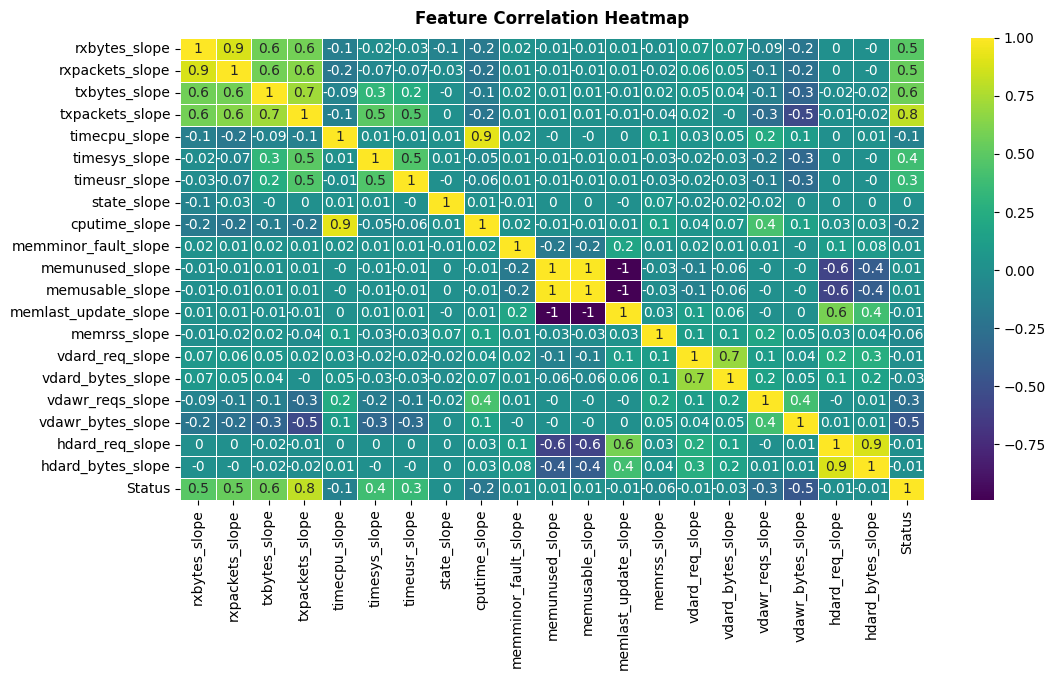

In [17]:
# Plot corr heatmap
plt.figure(figsize=(12,6), dpi =100)
sns.heatmap(round(df.drop(['rxerrors_slope', 'rxdrops_slope', 'txerrors_slope', 'txdrops_slope', 'memmax_slope',
                     'mem_slope','cpus_slope','memactual_slope','memswap_in_slope', 'memswap_out_slope',
                     'memmajor_fault_slope', 'memavailable_slope', 'memdisk_cache_slope','memhugetlb_pgalloc_slope',
                     'memhugetlb_pgfail_slope', 'vdaerror_slope', 'hdawr_reqs_slope', 'hdawr_bytes_slope','hdaerror_slope'
                     ] , axis=1).corr(), 2), linewidth=0.5,annot=True,fmt='.1g', cmap="viridis")
plt.title("Feature Correlation Heatmap", fontsize = 12, pad =10, fontweight='bold')

In [18]:
# Drop the 'Status' column from the DataFrame and store the result in X
X = df.drop(['Status'], axis=1)

In [19]:
# Select the 'Status' column from the DataFrame and store it in y
y = df['Status']


In [20]:
# Train test split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =1)

# Split data into train/test sets

<ipython-input-21-8c5abbcd6e9a>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-21-8c5abbcd6e9a>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




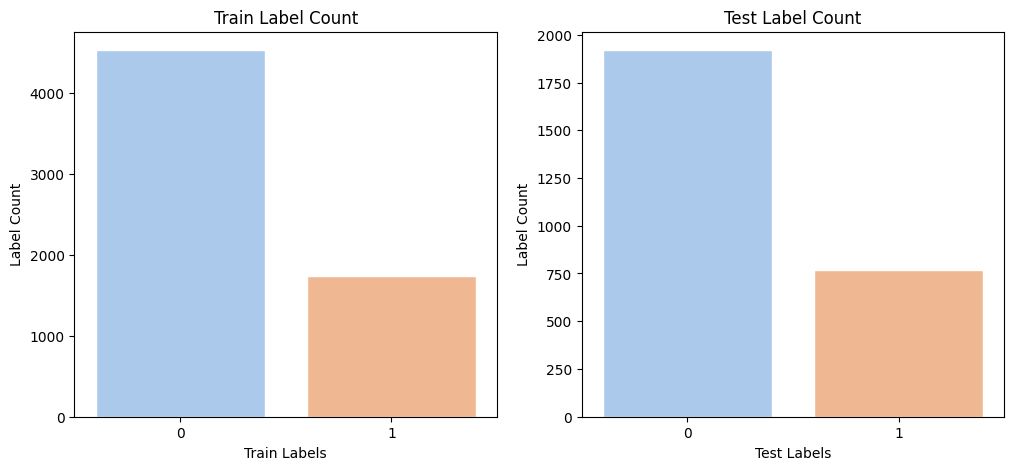

In [21]:
# Create subplots
fig, ax = plt.subplots(1,2, figsize=(12,5))

# Loop through Train and Test data to create bar plots for train/test
for idx, group in enumerate([('Train', y_train), ('Test', y_test)]):
    data = group[1].value_counts()
    sns.set_theme(style="whitegrid")
    sns.barplot(ax=ax[idx], x=data.index, y=data.values,palette="pastel")
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

plt.show()

# Xgboost

In [22]:
xgb.__version__

'2.0.3'

In [23]:
df.dtypes

rxbytes_slope               float64
rxpackets_slope             float64
rxerrors_slope              float64
rxdrops_slope               float64
txbytes_slope               float64
txpackets_slope             float64
txerrors_slope              float64
txdrops_slope               float64
timecpu_slope               float64
timesys_slope               float64
timeusr_slope               float64
state_slope                 float64
memmax_slope                float64
mem_slope                   float64
cpus_slope                  float64
cputime_slope               float64
memactual_slope             float64
memswap_in_slope            float64
memswap_out_slope           float64
memmajor_fault_slope        float64
memminor_fault_slope        float64
memunused_slope             float64
memavailable_slope          float64
memusable_slope             float64
memlast_update_slope        float64
memdisk_cache_slope         float64
memhugetlb_pgalloc_slope    float64
memhugetlb_pgfail_slope     

In [24]:
y_train.count()

6267

# Calculate Negative-Positive Rate of data (Imbalance Ratio)

In [25]:
# Calculate the negative to positive rate
imbalance_ratio = (y_train.count() - y_train.sum()) / y_train.sum()

# Print the attack to normal rate
print("Attack to normal rate: ", imbalance_ratio)


Attack to normal rate:  3.6017241379310345


# To handle the imbalanced input data:

# 1. Adding Scale_Pos_Weight as parameter for xgboost grid search to find the most effective value that can handle class imbalance

# 2. Adding Stratified KFold object for cross validation to consider imbalance in data in train/test sets

In [26]:
# Define model parameters
model_params = {
    'eval_metric': ["aucpr", "logloss"],
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'binary:logistic'
}

# Define parameter grid for GridSearchCV
param_grid = {
    "max_depth": [2, 4, 6, 8],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [imbalance_ratio / 1.5, imbalance_ratio, imbalance_ratio * 1.2, imbalance_ratio * 1.8],
    "subsample": [0.8],
    "colsample_bytree": [1, 0.5]
}

# Initialize the XGBoost classifier
xgb_cl = xgb.XGBClassifier(**model_params)

# Create a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_cv = GridSearchCV(
    estimator=xgb_cl,
    param_grid=param_grid,
    n_jobs=-1,
    cv=stratified_kfold,
    scoring="average_precision"
)

# Fit the model
grid_cv.fit(X_train, y_train, verbose=3)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=['aucpr', 'logloss'],
                                     feature_types=None, gamma=None,
                                     grow_policy=None...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1, 0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [2, 4, 6, 8], 'reg_lambda': [0, 1, 10],
                         'scale_pos_weight': [2.401149425287356,
                                              3.6017241379310345,
                                              4.322068965517241,
                                              6.4831034482758625],
                         'subsample': [0.8]},
             scoring='average_precision')

In [27]:
# Extract the best parameters from the grid search
xgb_best_params = grid_cv.best_params_

print("Best XGB Hyperparameters:", xgb_best_params)
print("\nBest XGB aucpr:", grid_cv.best_score_)

Best XGB Hyperparameters: {'colsample_bytree': 1, 'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 0, 'scale_pos_weight': 4.322068965517241, 'subsample': 0.8}

Best XGB aucpr: 0.8506439429824689


## Build XGB Model based on best parameters found via grid search

In [28]:
# Retrieve the best estimator from the grid search
best_xgb_model = grid_cv.best_estimator_

# Fit the best model on the training data with evaluation on both training and test sets
best_xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

# Save the model to a file
model_filename = 'xgb_model.joblib'
dump(best_xgb_model, model_filename)

[0]	validation_0-aucpr:0.88501	validation_0-logloss:0.78634	validation_1-aucpr:0.76587	validation_1-logloss:0.78670
[10]	validation_0-aucpr:0.97318	validation_0-logloss:0.50604	validation_1-aucpr:0.86544	validation_1-logloss:0.53135
[20]	validation_0-aucpr:0.98379	validation_0-logloss:0.37272	validation_1-aucpr:0.86974	validation_1-logloss:0.41552
[30]	validation_0-aucpr:0.98490	validation_0-logloss:0.29414	validation_1-aucpr:0.87324	validation_1-logloss:0.35403
[40]	validation_0-aucpr:0.98677	validation_0-logloss:0.24531	validation_1-aucpr:0.86809	validation_1-logloss:0.32308
[50]	validation_0-aucpr:0.98894	validation_0-logloss:0.20908	validation_1-aucpr:0.86728	validation_1-logloss:0.30370
[60]	validation_0-aucpr:0.99082	validation_0-logloss:0.18098	validation_1-aucpr:0.86994	validation_1-logloss:0.29311
[70]	validation_0-aucpr:0.99326	validation_0-logloss:0.15817	validation_1-aucpr:0.86927	validation_1-logloss:0.28671
[80]	validation_0-aucpr:0.99581	validation_0-logloss:0.13652	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['aucpr', 'logloss'], feature_types=None, gamma=0.25,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

# Display Confusion matrix, Percision, Recall, F1-Score for XGB model with best parameters found via hyperparametrs tuning

Classification Report
              precision    recall  f1-score   support

           0     0.9280    0.9797    0.9531      1920
           1     0.9409    0.8096    0.8704       767

    accuracy                         0.9311      2687
   macro avg     0.9344    0.8947    0.9117      2687
weighted avg     0.9317    0.9311    0.9295      2687



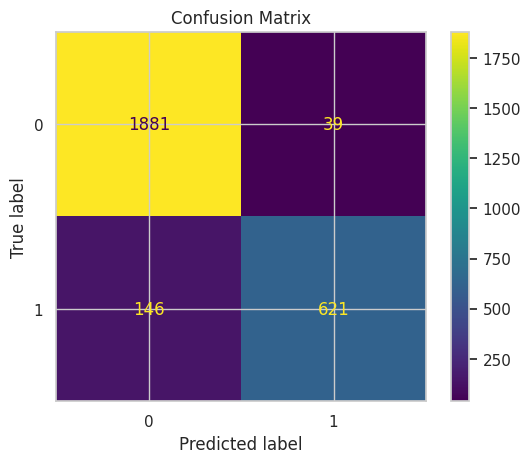

In [29]:
# Make predictions on the test set using the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)


print('Classification Report')
print(classification_report(y_test, y_pred_xgb, digits=4))

# Create confusion matrix display
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

## Get feature names from XGB booster object & Display feature importance

In [30]:
# Get the booster object from the best XGBoost model
booster = best_xgb_model.get_booster()

# Set feature names in the booster object to match the columns of X_train
booster.feature_names = X_train.columns.tolist()

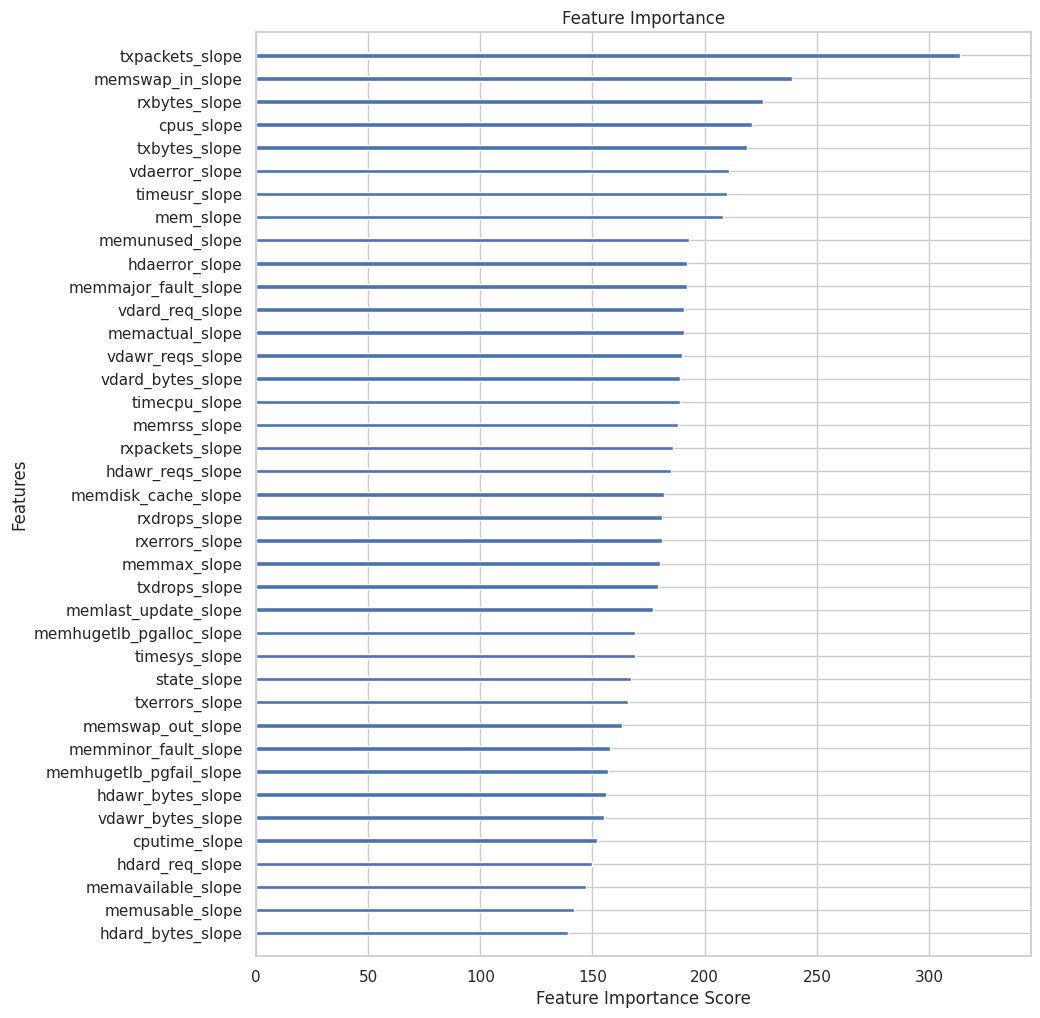

In [31]:
plt.figure(figsize=(10, 12))

# Plot feature importance using the booster object
plot_importance(booster, importance_type='weight', show_values=False, xlabel='Feature Importance Score', ylabel='Features', ax=plt.gca())

plt.title('Feature Importance')
plt.show()


# Display ROC curve

AUC: 0.889774826162538


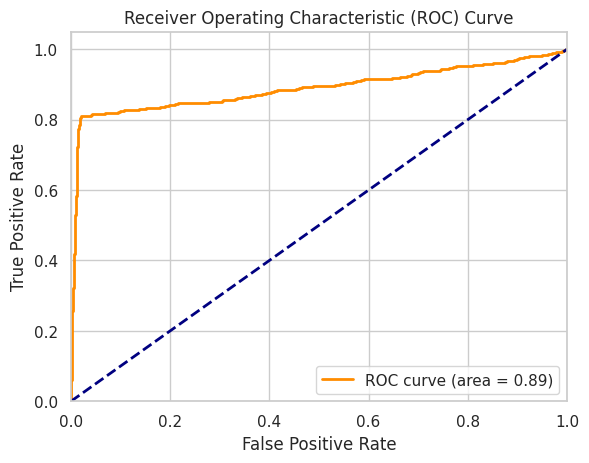

In [34]:
# Predict probabilities for the test set
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display Percision Recall plot for imbalance data which focuses on performance with minor class

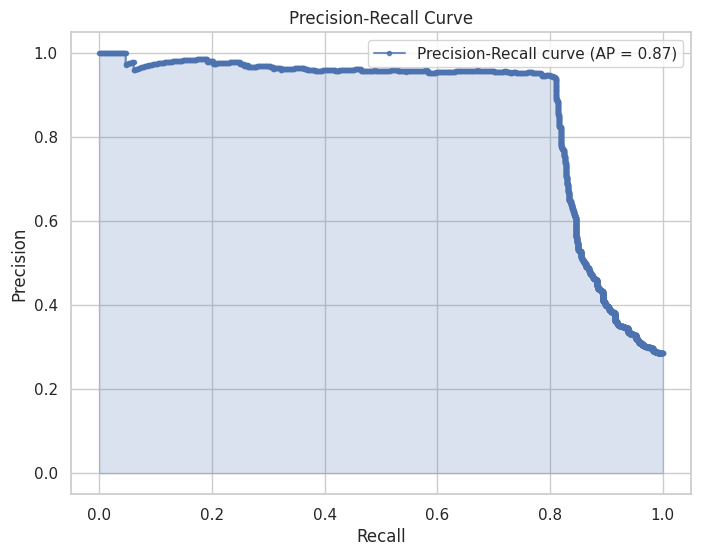

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='b', alpha=0.8, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()